In [1]:
import pandas as pd
import numpy as np

from scipy.io import arff
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

data = arff.loadarff('dataset')
print(f"Data dimensions: {len(data)} x {data[0].shape}")

Data dimensions: 2 x (303,)


In [2]:
dataset = pd.DataFrame(data[0]).drop(columns=["id"])
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0


In [3]:
print(data[1])

Dataset: Heart-Disease-patients
	id's type is numeric
	age's type is numeric
	sex's type is numeric
	cp's type is numeric
	trestbps's type is numeric
	chol's type is numeric
	fbs's type is numeric
	restecg's type is numeric
	thalach's type is numeric
	exang's type is numeric
	oldpeak's type is numeric
	slope's type is numeric



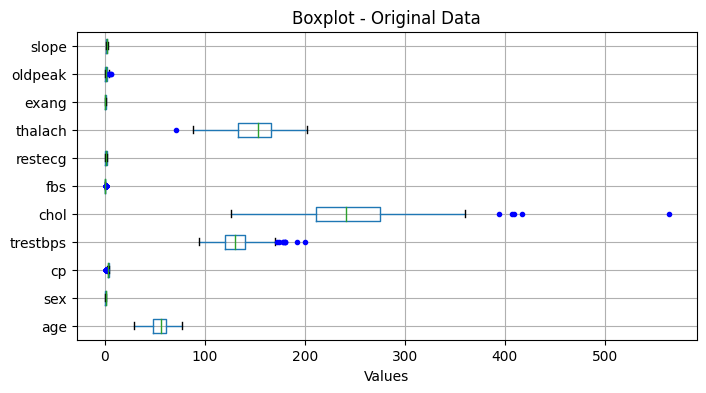

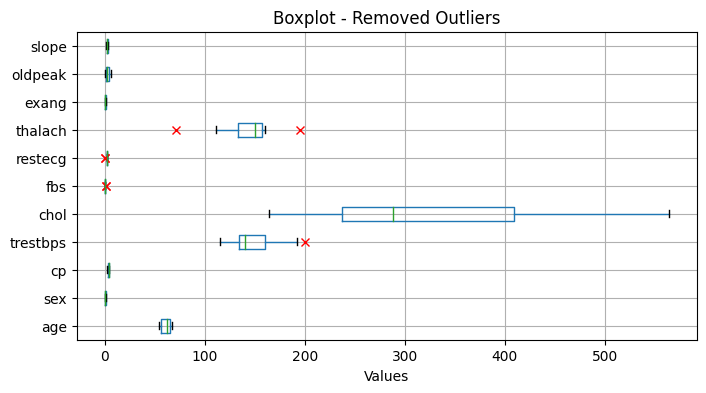

In [4]:
# Copy the dataset for outlier detection
dataset_copy = dataset.copy()

# Define a threshold for outlier detection (e.g., Z-score > 3 or Z-score < -3)
threshold = 3

# Calculate the Z-scores for each column in the dataset
z_scores = np.abs(stats.zscore(dataset_copy))

# Create a mask to identify outliers
outlier_mask = (z_scores > threshold).any(axis=1)

# Separate the outliers and non-outliers
outliers = dataset_copy[outlier_mask]
non_outliers = dataset_copy[~outlier_mask]

# Create boxplots to visualize the original dataset
plt.figure(figsize=(8, 4))
dataset_copy.boxplot(sym='b.', vert=False)
plt.xlabel('Values')
plt.title('Boxplot - Original Data')
plt.show()

# Visualize the outliers separately with boxplots
plt.figure(figsize=(8, 4))
outliers.boxplot(sym='rx', vert=False)
plt.xlabel('Values')
plt.title('Boxplot - Removed Outliers')
plt.show()

In [5]:
dataset = dataset_copy[~outlier_mask]

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

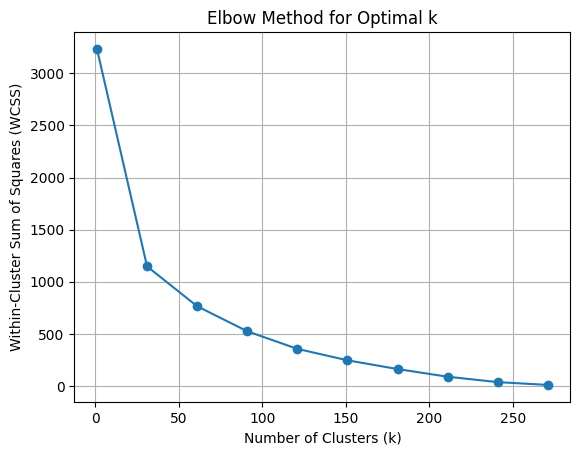

In [7]:
# Define a range of possible k values to try (e.g., from 1 to 10)
k_values = range(1, 300, 30)

# Initialize a list to store the within-cluster sum of squares (WCSS) for each k
wcss_values = []

# Calculate WCSS for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_data)
    wcss_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, wcss_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

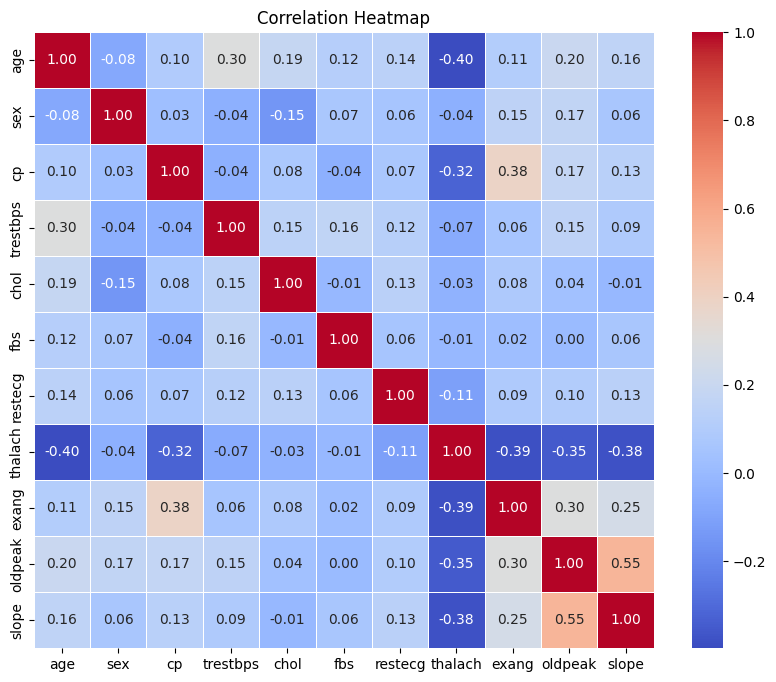

In [8]:
# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Set the plot size (optional)
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Heatmap")
plt.show()

Explained Variance Ratio for k=4: [0.23403801 0.13262741 0.110157   0.09235932]


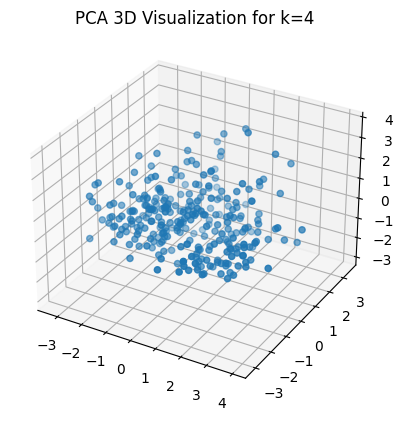

In [9]:
k=4    

# Initialize PCA with the specified number of components
pca = PCA(n_components=k)

# Fit PCA to the scaled data
pca.fit(scaled_data)

# Transform the data to the lower-dimensional space
pca_result = pca.transform(scaled_data)

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio for k={k}:", explained_variance_ratio)

# Create a new figure for each value of k
fig = plt.figure()

# 3D Visualization for k=3
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])
plt.title(f'PCA 3D Visualization for k={k}')

plt.show()

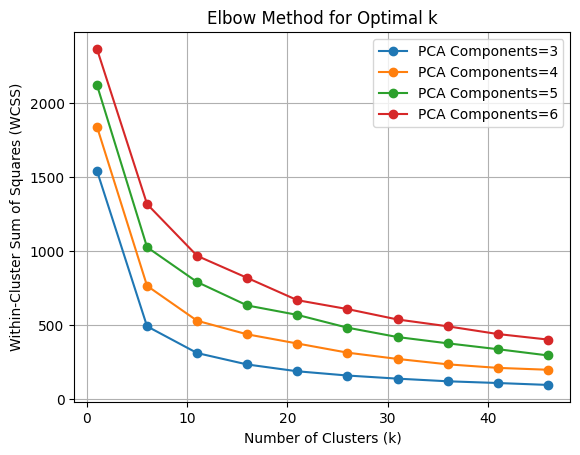

In [10]:
# Define a range of possible k values to try (e.g., from 1 to 10)
k_values = range(1, 50, 5)
j_values = range(3, 7)

# Initialize a list to store the within-cluster sum of squares (WCSS) for each k
wcssj_values = []

for j in j_values:
    wcss_values = []
    for k in k_values:
        # Initialize PCA with the specified number of components
        pca = PCA(n_components=j)
        # Fit PCA to the scaled data
        pca.fit(scaled_data)

        # Transform the data to the lower-dimensional space
        pca_result = pca.transform(scaled_data)

        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans_labels = kmeans.fit_predict(pca_result)
        wcss_values.append(kmeans.inertia_)

    # Append the wcss_values list to the wcssj_values list for each value of j
    wcssj_values.append(wcss_values)

# Plot the elbow curve for each value of j
for j, wcss_values in zip(j_values, wcssj_values):
    plt.plot(k_values, wcss_values, marker='o', label=f'PCA Components={j}')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Initialize PCA with the specified number of components
pca = PCA(n_components=4)
# Fit PCA to the scaled data
pca.fit(scaled_data)

# Transform the data to the lower-dimensional space
pca_result = pca.transform(scaled_data)

# Define a range of possible k values to try (e.g., from 1 to 10)
k_values = range(2, 12, 1)

# Initialize a list to store the within-cluster sum of squares (WCSS) for each k
scores = {}
# Calculate WCSS for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(pca_result)
    scores[k] = silhouette_score(pca_result, kmeans_labels)
print("Scores for k values: ")
scores

Scores for k values: 


{2: 0.28376186659009595,
 3: 0.25482539662372433,
 4: 0.2080075541539422,
 5: 0.23487121819174459,
 6: 0.2276341078996477,
 7: 0.2347549750298325,
 8: 0.24027449161778752,
 9: 0.2246732986817059,
 10: 0.21002833336339122,
 11: 0.2195470219153889}

In [22]:
# Acho que vamos ter que diminuir as componentes da PCA... por mais q a gente tenha consiga bons resultados, 
# tá bem complicada a explicabilidade desse negócio
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=dataset.columns)

loadings_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.319963,0.094465,0.297047,0.181427,0.113551,0.069065,0.190157,-0.457327,0.387235,0.432458,0.409396
1,0.431139,-0.362790,-0.229184,0.505763,0.419219,0.244163,0.212139,0.066923,-0.233393,-0.137821,-0.125987
2,-0.041887,0.446669,-0.446947,0.233950,-0.391554,0.476981,0.073507,0.138160,-0.182524,0.217843,0.241143
3,0.121083,-0.437712,-0.309280,0.010919,-0.187698,-0.370599,-0.433112,-0.119460,-0.301938,0.298512,0.378506


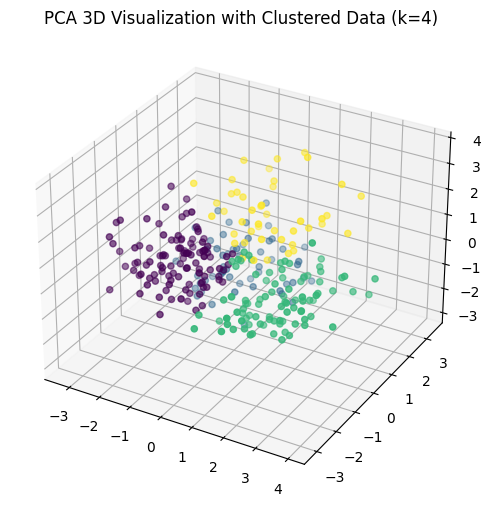

In [12]:

num_clusters = 4

# Create K-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
kmeans_labels = kmeans.fit_predict(pca_result)

# Visualization of PCA 3D and Clustered Data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=kmeans_labels, cmap='viridis')
ax.set_title('PCA 3D Visualization with Clustered Data (k={})'.format(num_clusters))
plt.show()

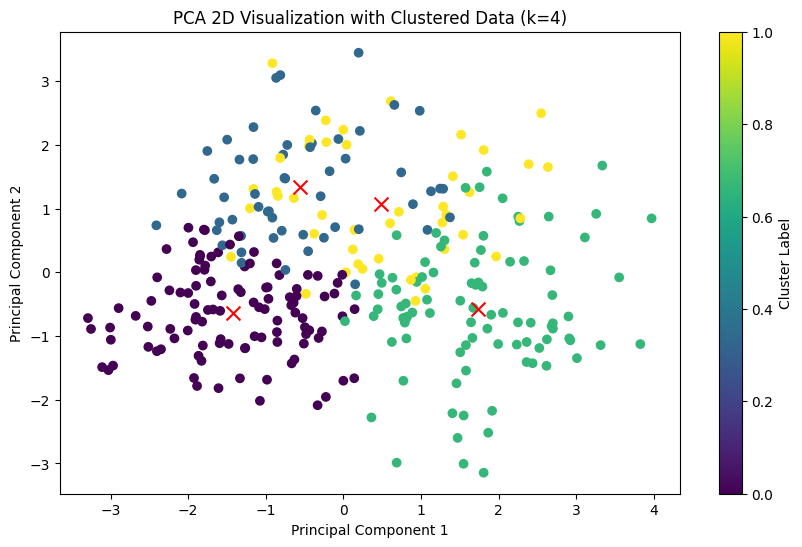

In [13]:
# Visualization of PCA 2D and Clustered Data
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Visualization with Clustered Data (k={})'.format(num_clusters))
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
# Visualization of PCA 3D and Clustered Data using plotly
fig = px.scatter_3d(x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2],
                    color=kmeans_labels, color_continuous_scale='viridis')
fig.update_layout(scene=dict(xaxis_title='Custom X Label',
                             yaxis_title='Custom Y Label',
                             zaxis_title='Custom Z Label'),
                             title='PCA 3D Visualization with Clustered Data (k={})'.format(num_clusters))
fig.show()